# Neural Style Transfer Exp:1
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- Reconstructing content from different layers with no style
- Reconstructing style from different layers with no content
- Reconstructing style from different layers keeping content fixed

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

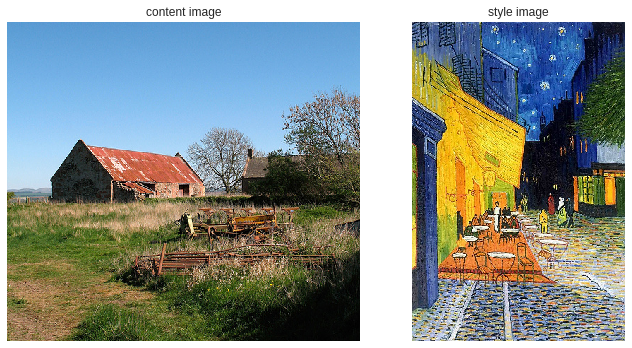

In [6]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

!wget -qq http://farm1.static.flickr.com/202/480492895_711231246a.jpg -O {PATH_IMAGES}/farm.jpg
content_img = open_image(PATH_IMAGES/'farm.jpg')

!wget -qq https://media.overstockart.com/optimized/cache/data/product_images/VG1540-1000x1000.jpg -O {PATH_STYLE}/'cafe_terrace.jpg'
style_img = open_image(PATH_STYLE/'cafe_terrace.jpg')

images = [content_img,style_img]
titles = ['content image', 'style image']

fig,axes = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(titles[i])
    ax.imshow(images[i]);
plt.tight_layout()
plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

In [144]:
t2.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

## Reconstructing content from different layers with no style

Reconstructing content from layer 2...
content: 285.3267826139927, style: 0.0
content: 0.08613102181698196, style: 0.0
content: 8.820291164113314e-05, style: 0.0
content: 2.2770081653522567e-06, style: 0.0
content: 9.845545385911425e-08, style: 0.0
content: 1.2076571296801286e-08, style: 0.0
content: 5.295563250060087e-09, style: 0.0
content: 4.685236031608253e-09, style: 0.0
content: 4.318150654755715e-09, style: 0.0
content: 4.0519345691214514e-09, style: 0.0
content: 3.8419473765566314e-09, style: 0.0
Reconstructing content from layer 9...
content: 212.73598074913025, style: 0.0
content: 14.817676274105906, style: 0.0
content: 8.349415729753673, style: 0.0
content: 6.718133226968348, style: 0.0
content: 5.947814788669348, style: 0.0
content: 5.6034274166449904, style: 0.0
content: 5.451845936477184, style: 0.0
content: 5.369383725337684, style: 0.0
content: 5.300685879774392, style: 0.0
content: 5.226623616181314, style: 0.0
content: 5.138301057741046, style: 0.0
Reconstructing cont

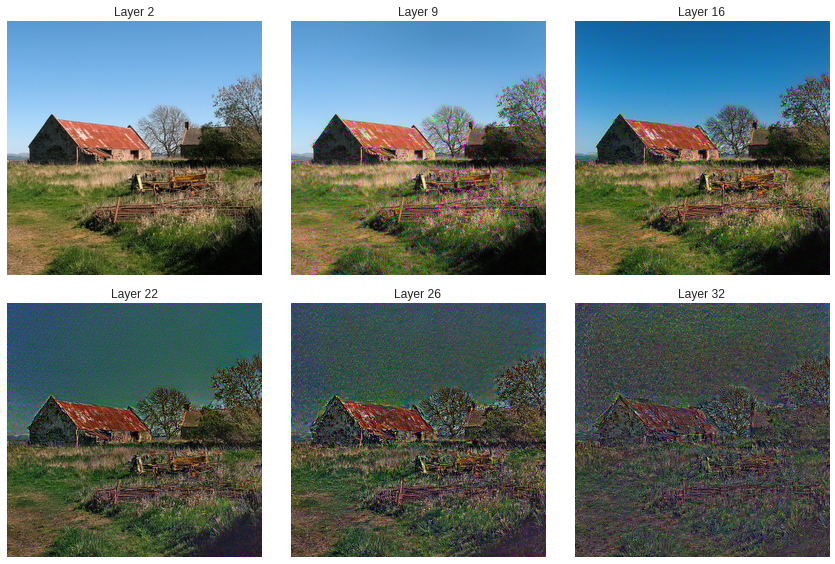

In [145]:
content_layers_to_use = [2,9,16,22,26,32]

n_cols = 3
n_rows = ceil(len(content_layers_to_use)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==len(content_layers_to_use):
        break
    print(f'Reconstructing content from layer {content_layers_to_use[i]}...')
    

    ax.set_title(f'Layer {content_layers_to_use[i]}')
    gen4 = t2.generate(content_img, style_img,
                       content_layers=[content_layers_to_use[i]],
                       style_layers=[10],
                       alpha=1e4,
                       beta=0.,
                       style_layers_weights=None,
                       max_iter=1000,show_iter=100,
                       print_losses=True,
                       scale_style_img=True)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()   
fig_name = f'v2-content-reconstructions-1.png'
plt.savefig(fig_name)
plt.show()
!cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/

## Reconstructing style from different layers with no content

Reconstructing style from layer 9...
content: 0.0, style: 4226.75
content: 0.0, style: 56.892704010009766
content: 0.0, style: 18.018518447875977
content: 0.0, style: 7.377061367034912
content: 0.0, style: 3.328282356262207
content: 0.0, style: 1.6355701684951782
Reconstructing style from layer 16...
content: 0.0, style: 667.9899291992188
content: 0.0, style: 1.9938913583755493
content: 0.0, style: 0.637028157711029
content: 0.0, style: 0.3170064389705658
content: 0.0, style: 0.18906530737876892
content: 0.0, style: 0.1274072527885437
Reconstructing style from layer 22...
content: 0.0, style: 111.85639953613281
content: 0.0, style: 0.2855675220489502
content: 0.0, style: 0.10686879605054855
content: 0.0, style: 0.06247030571103096
content: 0.0, style: 0.04369465261697769
content: 0.0, style: 0.03341929614543915
Reconstructing style from layer 26...
content: 0.0, style: 33.242828369140625
content: 0.0, style: 0.1931716352701187
content: 0.0, style: 0.12210254371166229
content: 0.0, styl

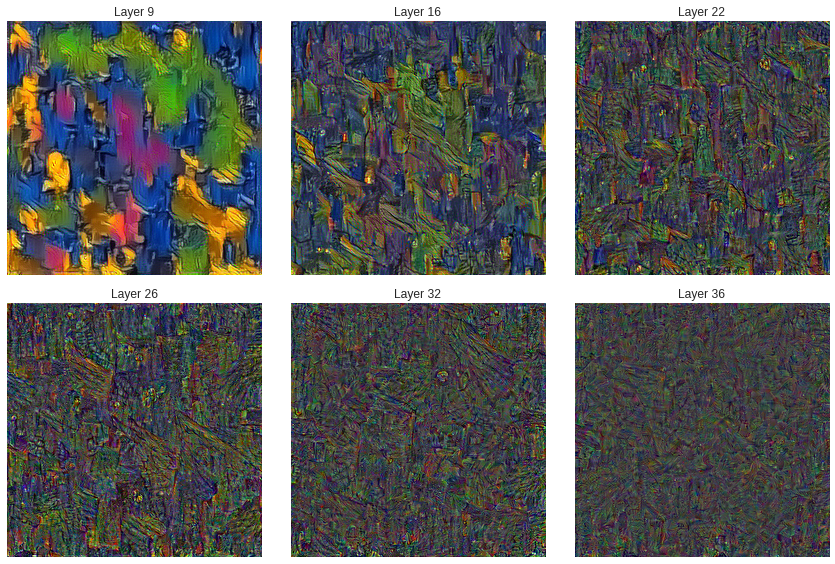

In [148]:
style_layers_to_use = [9,16,22,26,32,36]

n_cols = 3
n_rows = ceil(len(style_layers_to_use)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==len(style_layers_to_use):
        break
    print(f'Reconstructing style from layer {style_layers_to_use[i]}...')
    

    ax.set_title(f'Layer {style_layers_to_use[i]}')
    gen4 = t2.generate(content_img, style_img,
                       content_layers=[16],
                       style_layers=[style_layers_to_use[i]],
                       alpha=0.,
                       beta=1.,
                       style_layers_weights=None,
                       max_iter=500,show_iter=100,
                       print_losses=True,
                       scale_style_img=True)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()   
fig_name = f'v2-style-reconstructions-1.png'
plt.savefig(fig_name)
plt.show()
!cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/

## Reconstructing style from different layers keeping content fixed

Reconstructing style from layers [2, 5, 9, 12, 16]...
content: 3450.2439200878143, style: 399575.71875
content: 1840.767078101635, style: 737.7928466796875
content: 1352.8050854802132, style: 274.9574279785156
content: 1191.7918920516968, style: 215.7274169921875
content: 1103.5004630684853, style: 194.51385498046875
content: 1043.5468517243862, style: 181.315673828125
content: 1000.781636685133, style: 174.06875610351562
content: 969.5611894130707, style: 169.08712768554688
content: 945.6701576709747, style: 165.8045196533203
Reconstructing style from layers [9, 12, 16, 22, 26]...
content: 3436.4916384220123, style: 13329.6533203125
content: 870.429165661335, style: 455.8583068847656
content: 657.7258463948965, style: 340.3421325683594
content: 577.9290571808815, style: 297.2373046875
content: 535.040907561779, style: 272.40728759765625
content: 509.0300925076008, style: 258.501708984375
content: 492.47974529862404, style: 250.92950439453125
content: 482.04921185970306, style: 245.497

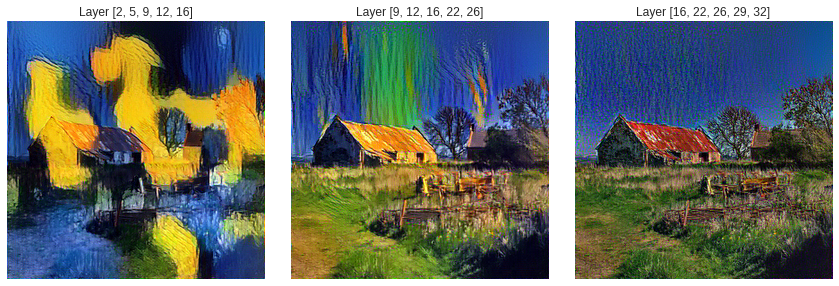

In [150]:
style_layers_to_use = [
    [2,5,9,12,16],
    [9,12,16,22,26],
    [16,22,26,29,32],
]

n_cols = 3
n_rows = ceil(len(style_layers_to_use)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==len(style_layers_to_use):
        break
    print(f'Reconstructing style from layers {style_layers_to_use[i]}...')
    

    ax.set_title(f'Layer {style_layers_to_use[i]}')
    gen4 = t2.generate(content_img, style_img,
                       content_layers=[19,22],
                       style_layers=style_layers_to_use[i],
                       alpha=1e5,
                       beta=1.,
                       style_layers_weights=None,
                       max_iter=800,show_iter=100,
                       print_losses=True,
                       scale_style_img=True)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()   
fig_name = f'v2-style-reconstructions-with-fixed-content-1.png'
plt.savefig(fig_name)
plt.show()
!cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/